In [1]:
import kagglehub
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import seaborn as sns
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [2]:
print(os.listdir(r"C:\Users\maria\.cache\kagglehub\datasets\gpiosenka\sports-classification\versions\9"))

['EfficientNetB0-100-(224 X 224)- 98.40.h5', 'sports.csv', 'test', 'train', 'valid']


In [3]:
path = r"C:\Users\maria\.cache\kagglehub\datasets\gpiosenka\sports-classification\versions\9"

for f in os.listdir(path):
    print(f, " -> ", os.path.join(path, f))

EfficientNetB0-100-(224 X 224)- 98.40.h5  ->  C:\Users\maria\.cache\kagglehub\datasets\gpiosenka\sports-classification\versions\9\EfficientNetB0-100-(224 X 224)- 98.40.h5
sports.csv  ->  C:\Users\maria\.cache\kagglehub\datasets\gpiosenka\sports-classification\versions\9\sports.csv
test  ->  C:\Users\maria\.cache\kagglehub\datasets\gpiosenka\sports-classification\versions\9\test
train  ->  C:\Users\maria\.cache\kagglehub\datasets\gpiosenka\sports-classification\versions\9\train
valid  ->  C:\Users\maria\.cache\kagglehub\datasets\gpiosenka\sports-classification\versions\9\valid


In [4]:
csv_path = os.path.join(path, "sports.csv")
df = pd.read_csv(csv_path)
print(df.head())
print(df.info())

   class id                 filepaths      labels data set
0         0  train/air hockey/001.jpg  air hockey    train
1         0  train/air hockey/002.jpg  air hockey    train
2         0  train/air hockey/003.jpg  air hockey    train
3         0  train/air hockey/004.jpg  air hockey    train
4         0  train/air hockey/005.jpg  air hockey    train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14493 entries, 0 to 14492
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class id   14493 non-null  int64 
 1   filepaths  14493 non-null  object
 2   labels     14493 non-null  object
 3   data set   14493 non-null  object
dtypes: int64(1), object(3)
memory usage: 453.0+ KB
None


In [5]:
print("Classes:", df['class id'].unique())
print("Number of classes:", df['class id'].nunique())

counts = df['class id'].value_counts()
print(counts)

Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Number of classes: 100
class id
31    201
32    200
58    199
7     184
41    182
     ... 
44    112
3     109
99    108
91    107
77     69
Name: count, Length: 100, dtype: int64


In [6]:
train_count = df['filepaths'].str.startswith('train/').sum()
valid_count = df['filepaths'].str.startswith('valid/').sum()
test_count  = df['filepaths'].str.startswith('test/').sum()

print(f"Train images: {train_count}")
print(f"Valid images: {valid_count}")
print(f"Test images: {test_count}")

Train images: 13493
Valid images: 500
Test images: 500


In [7]:
train_counts = df[df['filepaths'].str.startswith('train/')]['class id'].value_counts()
print("Train counts per class:")
print(train_counts)

valid_counts = df[df['filepaths'].str.startswith('valid/')]['class id'].value_counts()
print("\nValidation counts per class:")
print(valid_counts)

test_counts = df[df['filepaths'].str.startswith('test/')]['class id'].value_counts()
print("\nTest counts per class:")
print(test_counts)

Train counts per class:
class id
31    191
32    190
58    189
7     174
41    172
     ... 
44    102
3      99
99     98
91     97
77     59
Name: count, Length: 100, dtype: int64

Validation counts per class:
class id
0     5
1     5
2     5
3     5
4     5
     ..
95    5
96    5
97    5
98    5
99    5
Name: count, Length: 100, dtype: int64

Test counts per class:
class id
0     5
1     5
2     5
3     5
4     5
     ..
95    5
96    5
97    5
98    5
99    5
Name: count, Length: 100, dtype: int64


([], [])

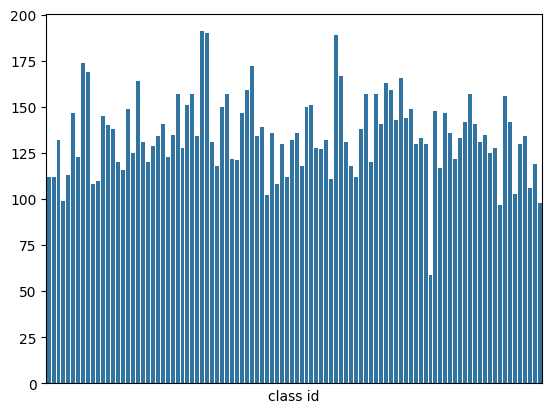

In [8]:
sns.barplot(x=train_counts.index, y=train_counts.values)
plt.xticks([])

([], [])

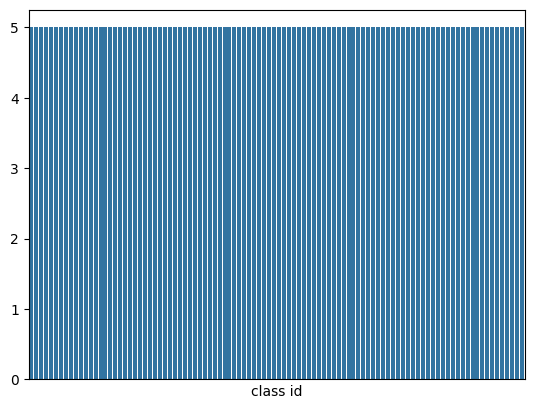

In [9]:
sns.barplot(x=valid_counts.index, y=valid_counts.values)
plt.xticks([])

([], [])

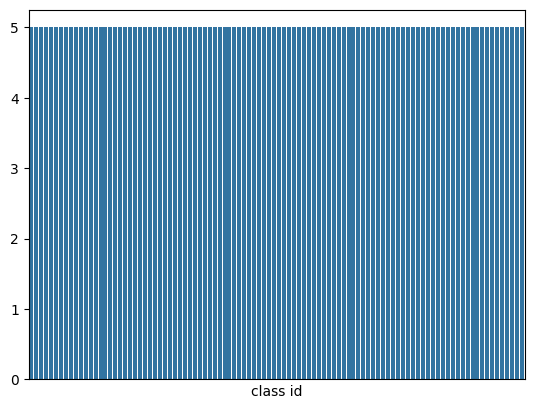

In [10]:
sns.barplot(x=test_counts.index, y=test_counts.values)
plt.xticks([])

In [11]:
sizes = []
rows_to_drop = []


valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif")

for idx,img_path in df['filepaths'].items():
    full_path = os.path.normpath(os.path.join(path, img_path))
    

    if not os.path.exists(full_path):
        rows_to_drop.append(idx)
        continue
    

    if not full_path.lower().endswith(valid_extensions):
        rows_to_drop.append(idx)
        continue

    img = Image.open(full_path)
    sizes.append(img.size)

if sizes:
    widths, heights = zip(*sizes)
    print("Width: min =", min(widths), "max =", max(widths))
    print("Height: min =", min(heights), "max =", max(heights))
else:
    print("No valid images found!")

df_clean = df.drop(index=rows_to_drop).reset_index(drop=True)

print(f"Dropped {len(rows_to_drop)} invalid images")
print(f"Remaining images: {len(df_clean)}")


Width: min = 224 max = 224
Height: min = 224 max = 224
Dropped 1 invalid images
Remaining images: 14492


In [12]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

NUM_CLASSES = df_clean['class id'].nunique()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00022363663..0.9746734].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0945766..1.1794541].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13679197..1.2172749].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09395343..1.0989403].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12424685..1.0600684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0862488..0.8109149].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027

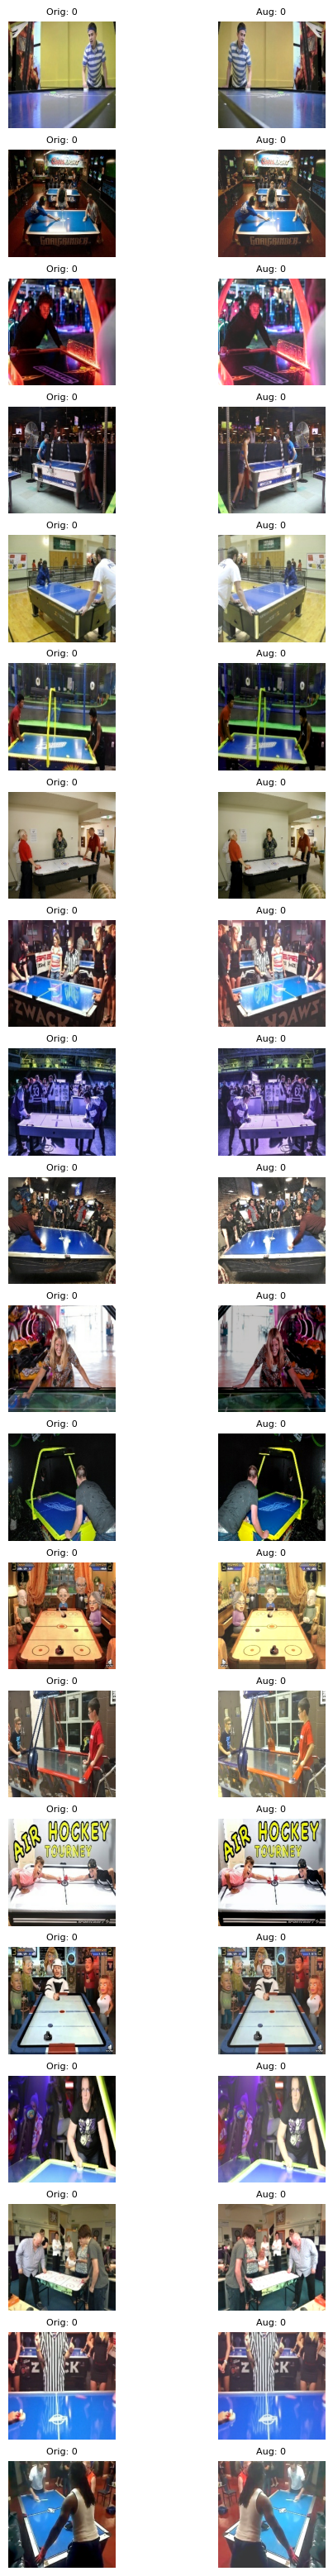



___IMAGE 0 (numeric values)___

[[[0.44313726 0.28627452 0.1882353 ]
  [0.21960784 0.07450981 0.        ]
  [0.1882353  0.0627451  0.01960784]
  ...
  [0.10196079 0.10980392 0.05490196]
  [0.08627451 0.09019608 0.06666667]
  [0.08627451 0.09411765 0.07450981]]

 [[0.48235294 0.31764707 0.21960784]
  [0.21960784 0.07058824 0.        ]
  [0.21176471 0.08627451 0.04313726]
  ...
  [0.10196079 0.10196079 0.05490196]
  [0.10196079 0.10588235 0.07450981]
  [0.08627451 0.09411765 0.07450981]]

 [[0.49803922 0.32156864 0.2       ]
  [0.3764706  0.21176471 0.11764706]
  [0.24313726 0.10196079 0.04705882]
  ...
  [0.10588235 0.10588235 0.05882353]
  [0.09803922 0.10196079 0.07058824]
  [0.08235294 0.09411765 0.06666667]]

 ...

 [[0.16470589 0.19215687 0.37254903]
  [0.16862746 0.19607843 0.36862746]
  [0.18039216 0.20784314 0.37254903]
  ...
  [0.2509804  0.27058825 0.15294118]
  [0.27058825 0.29411766 0.15294118]
  [0.2627451  0.28627452 0.13725491]]

 [[0.14901961 0.1764706  0.34901962]
  [

In [20]:
def preprocess_image(img_path, label, augment=False):
    full_path = tf.strings.join([path, img_path], separator=os.sep)
    img = tf.io.read_file(full_path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([224, 224, 3])
    img = tf.cast(img, tf.float32) / 255.0

    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_saturation(img, 0.8, 1.2)
        img = tf.image.random_hue(img, 0.05)
    
    label = tf.one_hot(label, NUM_CLASSES)
    return img, label

def create_dataset(df_split, augment=False):
    paths = df_split['filepaths'].values
    labels = df_split['class id'].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: preprocess_image(x, y, augment), 
                num_parallel_calls=tf.data.AUTOTUNE)
        
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_df = df_clean[df_clean['filepaths'].str.startswith('train/')]
valid_df = df_clean[df_clean['filepaths'].str.startswith('valid/')]
test_df  = df_clean[df_clean['filepaths'].str.startswith('test/')]

train_ds_without_aug = create_dataset(train_df, augment=False)
train_ds = create_dataset(train_df, augment=True)
valid_ds = create_dataset(valid_df)
test_ds  = create_dataset(test_df)

orig_batch = next(iter(train_ds_without_aug))
aug_batch  = next(iter(train_ds))

orig_images, orig_labels = orig_batch
aug_images, aug_labels   = aug_batch

plt.figure(figsize=(6, 40)) 
num_images = min(20, orig_images.shape[0])  # avoid indexing errors

for i in range(num_images):
    # Original
    ax = plt.subplot(20, 2, 2*i + 1)
    plt.imshow(orig_images[i].numpy())
    plt.axis("off")
    plt.title(f"Orig: {tf.argmax(orig_labels[i]).numpy()}", fontsize=8)

    # Augmented
    ax = plt.subplot(20, 2, 2*i + 2)
    plt.imshow(aug_images[i].numpy())
    plt.axis("off")
    plt.title(f"Aug: {tf.argmax(aug_labels[i]).numpy()}", fontsize=8)

plt.show()

# Numeric values of the first image
print("\n\n___IMAGE 0 (numeric values)___\n")
print(orig_images[0].numpy())